# XGBoost

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import os


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

_FOLDER = "fitted_datasets_CCL/"
_FOLDER_2 = "test_train/"
_FOLDER_3 = "Boosting_results/"
_FOLDER_4 = "fitted_datasets_2/"


import json

## Coding

In [5]:
# Define parameters and labels
params = ['param_1', 'param_2', 'param_3', 'param_4']
notIncludeColumns = ['COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID', 'MAX_CONC'] + params
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels

# Initialize storage for results
predictedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns=['DRUG_COSMICID'] + resp_labels + params)
performanceMetrics = []

# Load the original testing dataset
original_test_data = pd.read_csv(_FOLDER_4 + "Testing.csv")
X_test = original_test_data.drop(columns=notIncludeColumns + conc_labels + resp_labels)
y_test = original_test_data[resp_labels]

# Discover datasets and sort by sample size
dataset_files = [f for f in os.listdir(_FOLDER) if f.startswith("merged_drug_profiles_cells")]
dataset_sizes = {}
for dataset in dataset_files:
    df_temp = pd.read_csv(_FOLDER + dataset)
    dataset_sizes[dataset] = len(df_temp)

sorted_datasets = sorted(dataset_sizes.keys(), key=lambda x: dataset_sizes[x], reverse=True)

model = None

# Objective function for Optuna to optimize
def objective(trial, X_train, y_train, X_val, y_val):
    param = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    return mse

# Iterate through datasets to progressively improve the model
for iteration_number, dataset in enumerate(sorted_datasets):
    print(f"Processing dataset {iteration_number+1}/{len(sorted_datasets)}: {dataset}")
    drugProfiles = pd.read_csv(_FOLDER + dataset)

    # Prepare the datasets
    X = drugProfiles.drop(columns=notIncludeColumns + conc_labels + resp_labels)
    y = drugProfiles[resp_labels]

    # Split the data for training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    if model is None:
        # Run Optuna optimization only for the first dataset
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=100)
        
        best_params = study.best_params
        model = xgb.XGBRegressor(**best_params)
    else:
        # Decrease the learning rate as we move to more precise datasets
        new_learning_rate = max(0.01, model.get_params()['learning_rate'] * 0.9)
        # Incrementally increase the number of estimators
        additional_estimators = 50
        new_n_estimators = model.get_params()['n_estimators'] + additional_estimators

        # Update model parameters
        model.set_params(learning_rate=new_learning_rate, n_estimators=new_n_estimators)

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)

# Final evaluation on the original test set
preds = model.predict(X_test)

# Store predictions and true values
predictedResults = pd.DataFrame({'DRUG_COSMICID': original_test_data['DRUGID_COSMICID'], **{label: preds[:, i] for i, label in enumerate(pred_resp_labels)}})
trueResults = original_test_data[['DRUGID_COSMICID'] + resp_labels + params]

test_mse = mean_squared_error(y_test, preds, multioutput='raw_values')
performanceMetrics.append(test_mse)

# Output the performance
print("Final model performance:", performanceMetrics[-1])

   

Processing dataset 1/23: merged_drug_profiles_cells_scenario_3.15.csv.csv


[I 2024-03-12 16:09:40,017] A new study created in memory with name: no-name-37e20b6c-5535-4350-b6cc-07122066e449
C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\3876986952.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\3876986952.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecate

Processing dataset 2/23: merged_drug_profiles_cells_scenario_3.14.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 3/23: merged_drug_profiles_cells_scenario_3.13.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 4/23: merged_drug_profiles_cells_scenario_3.12.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 5/23: merged_drug_profiles_cells_scenario_3.11.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 6/23: merged_drug_profiles_cells_scenario_1.5.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 7/23: merged_drug_profiles_cells_scenario_3.10.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 8/23: merged_drug_profiles_cells_scenario_3.9.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 9/23: merged_drug_profiles_cells_scenario_1.4.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 10/23: merged_drug_profiles_cells_scenario_3.8.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 11/23: merged_drug_profiles_cells_scenario_3.7.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 12/23: merged_drug_profiles_cells_scenario_1.3.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 13/23: merged_drug_profiles_cells_scenario_3.6.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 14/23: merged_drug_profiles_cells_scenario_3.5.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 15/23: merged_drug_profiles_cells_scenario_3.4.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 16/23: merged_drug_profiles_cells_scenario_1.2.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 17/23: merged_drug_profiles_cells_scenario_3.3.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 18/23: merged_drug_profiles_cells_scenario_3.2.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 19/23: merged_drug_profiles_cells_scenario_3.1.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 20/23: merged_drug_profiles_cells_scenario_1.1.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 21/23: merged_drug_profiles_cells_scenario_2.3.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 22/23: merged_drug_profiles_cells_scenario_2.2.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Processing dataset 23/23: merged_drug_profiles_cells_scenario_2.1.csv.csv


C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Final model performance: [2.96506597e-05 1.64407084e-03 1.92071093e-02 4.93481848e-02
 8.84023932e-02 1.16076322e-01 9.37732897e-02 4.08605033e-02
 9.78025097e-03 9.46208962e-03]


In [25]:
predictedResults.to_csv(f"{_FOLDER_3}predicted_results.csv", index=False)
trueResults.to_csv(f"{_FOLDER_3}true_results2.csv", index=False)

## Analysis

In [26]:
def ll4_R(x, c, a, b, d):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
   
    a-d - difference between max and min responses
    np.exp( b* np.log(x) - e) -  np.exp((x-p)/s in Dennis Wang's sigmoid
    b - hill slope = 1/s - shape parameter
    np.log(x)- e/b == x-p in Dennis Wang's sigmoid

    """
    return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)

def getOptimalParamters(drug_curves):
    conc_labels = ["fd_num_"+str(i) for i in range(10)]
    resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
    drug_curves['param_1'] = None
    drug_curves['param_2'] = None
    drug_curves['param_3'] = None
    drug_curves['param_4'] = None
    for ind in range(len(drug_curves)):
        curve = drug_curves.loc[ind]
        XData = [0, 0.111111111, 0.222222222, 0.333333333, 0.444444444, 0.555555556, 0.666666667, 0.777777778, 0.888888889, 1]
        YData = curve[resp_labels].astype(float)
        function = ll4_R
        p0 = [0.4, 1.0, 1.0, 0.0]
        try:
            popt, pcov = curve_fit(function, XData, YData,p0, maxfev=6000, method='dogbox')
            drug_curves.at[ind, 'param_1'] = popt[0]
            drug_curves.at[ind, 'param_2'] = popt[1]
            drug_curves.at[ind, 'param_3'] = popt[2]
            drug_curves.at[ind, 'param_4'] = popt[3]
        except:
            print(curve)
    return drug_curves



In [29]:
predictedResults = pd.read_csv(f"{_FOLDER_3}predicted_results.csv")
predictedResults


,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,200_687819,0.994555,0.968698,0.870208,0.756989,0.575522,0.475815,0.374080,0.245005,0.185810,0.168736,-1.361306,0.992944,2.307047,-0.064349
1,1012_753594,0.994555,0.969499,0.898963,0.800092,0.649766,0.498505,0.359959,0.256109,0.150158,0.132577,-1.377871,0.984272,2.683216,-0.105545
2,1024_905965,0.994555,0.968460,0.896860,0.795677,0.650796,0.494177,0.335047,0.214449,0.133808,0.125003,-1.625368,0.978409,2.931105,-0.074546
3,1149_1247871,0.994555,0.968930,0.892773,0.771493,0.627151,0.462439,0.295148,0.180915,0.115440,0.105781,-1.764998,0.979382,2.944467,-0.075167
4,173_907280,0.994555,0.967171,0.888160,0.795902,0.664548,0.499246,0.356027,0.195461,0.124593,0.120170,-1.503078,0.974725,2.897981,-0.110916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,173_1240153,0.994555,0.970206,0.861344,0.764392,0.609195,0.458835,0.306440,0.247731,0.193563,0.193901,-2.015974,0.979389,2.871205,0.060078
496,157_909262,0.994555,0.969829,0.899531,0.796049,0.654176,0.491162,0.332020,0.210035,0.131409,0.129394,-1.722959,0.977833,3.025202,-0.056195
497,272_684055,0.994555,0.969780,0.894239,0.789507,0.637781,0.472614,0.316642,0.203733,0.137432,0.136787,-1.890466,0.977622,3.080722,-0.022503
498,104_1330981,0.994555,0.968192,0.896942,0.796269,0.664613,0.510894,0.333987,0.241712,0.192322,0.186690,-2.003651,0.973813,3.210979,0.049969


In [30]:
predictedOptimal = getOptimalParamters(predictedResults)
predictedOptimal

C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\U

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,200_687819,0.994555,0.968698,0.870208,0.756989,0.575522,0.475815,0.374080,0.245005,0.185810,0.168736,-1.361306,0.992944,2.307047,-0.064349
1,1012_753594,0.994555,0.969499,0.898963,0.800092,0.649766,0.498505,0.359959,0.256109,0.150158,0.132577,-1.377871,0.984272,2.683216,-0.105545
2,1024_905965,0.994555,0.968460,0.896860,0.795677,0.650796,0.494177,0.335047,0.214449,0.133808,0.125003,-1.625368,0.978409,2.931105,-0.074546
3,1149_1247871,0.994555,0.968930,0.892773,0.771493,0.627151,0.462439,0.295148,0.180915,0.115440,0.105781,-1.764998,0.979382,2.944467,-0.075167
4,173_907280,0.994555,0.967171,0.888160,0.795902,0.664548,0.499246,0.356027,0.195461,0.124593,0.120170,-1.503078,0.974725,2.897981,-0.110916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,173_1240153,0.994555,0.970206,0.861344,0.764392,0.609195,0.458835,0.306440,0.247731,0.193563,0.193901,-2.015974,0.979389,2.871205,0.060078
496,157_909262,0.994555,0.969829,0.899531,0.796049,0.654176,0.491162,0.332020,0.210035,0.131409,0.129394,-1.722959,0.977833,3.025202,-0.056195
497,272_684055,0.994555,0.969780,0.894239,0.789507,0.637781,0.472614,0.316642,0.203733,0.137432,0.136787,-1.890466,0.977622,3.080722,-0.022503
498,104_1330981,0.994555,0.968192,0.896942,0.796269,0.664613,0.510894,0.333987,0.241712,0.192322,0.186690,-2.003651,0.973813,3.210979,0.049969


In [10]:
predictedOptimal.to_csv(_FOLDER_3 +'boostingPredictedTuned.csv', index=False)

In [31]:
def showTestPredResponses(drugIdCosmic):
    samplePred = predictedOptimal[predictedOptimal['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    predY = samplePred[params]
    predY = np.array(predY[params]).squeeze()
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    trueY = np.array(trueY[params]).squeeze()
    print(trueY)
    xValues = np.linspace(0.0, 1.0, 500)
    
    plt.title(drugIdCosmic + " dosage against response")
    plt.plot(xValues, ll4_R(xValues, *trueY), color="b", label = "True")
    plt.plot(xValues, ll4_R(xValues, *predY), color="g", label = "Predicted")
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.legend()
    plt.show()

[-11.70829428   0.98066398  24.09052692   0.2601903 ]


C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


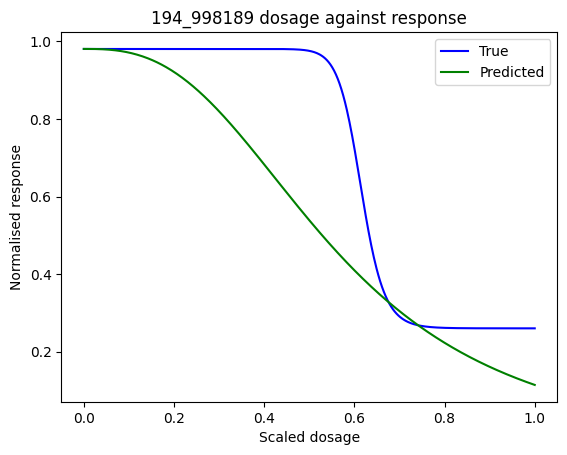

[-8.66721128  0.95362743  9.93707599  0.02732269]


C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


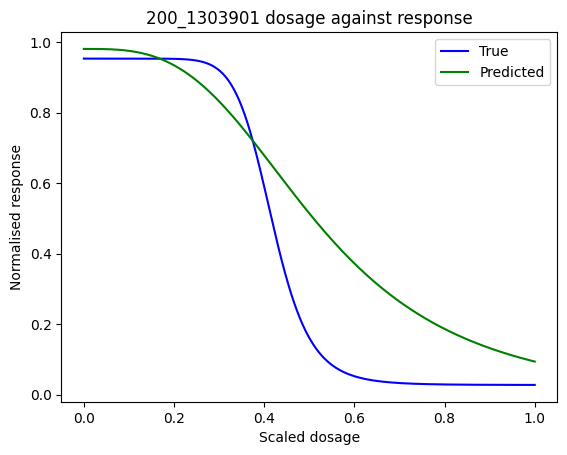

C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


[-13.13337256   1.01932593  13.1628236    0.0233717 ]


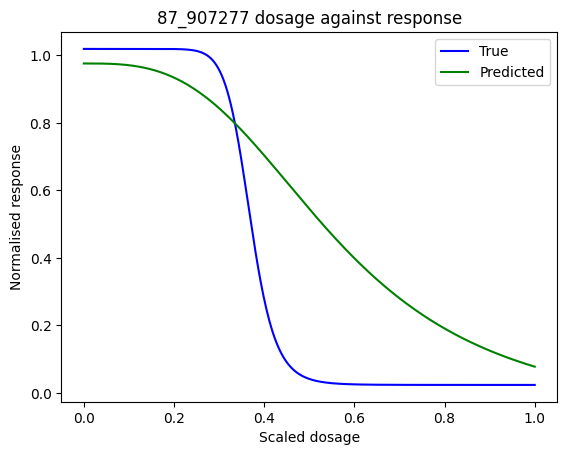

[-3.22168976  0.96463053  5.66747291 -0.05978004]


C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


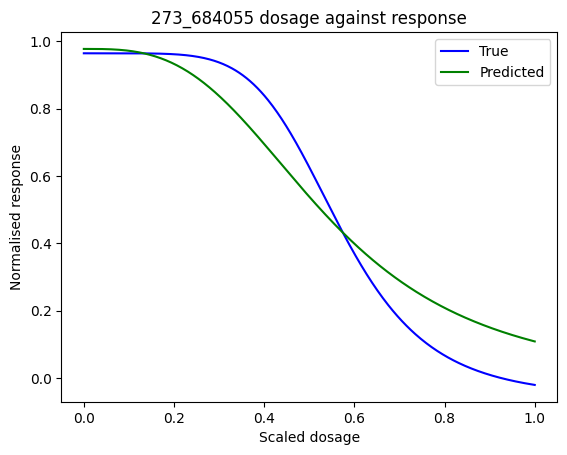

[-3.39173914  0.98512594 14.90383775  0.11269323]


C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


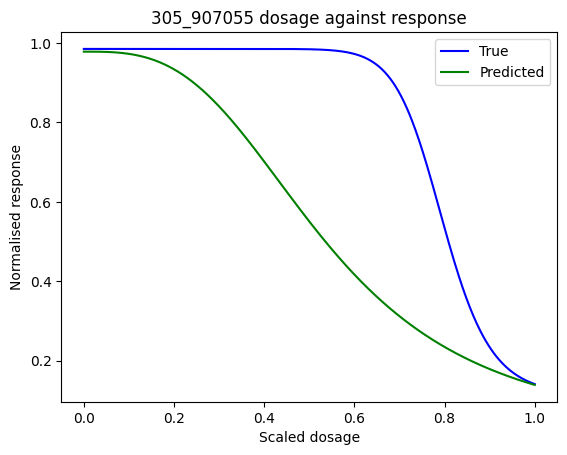

[-2.63316006  0.98195699  4.86587513 -0.07421014]


C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


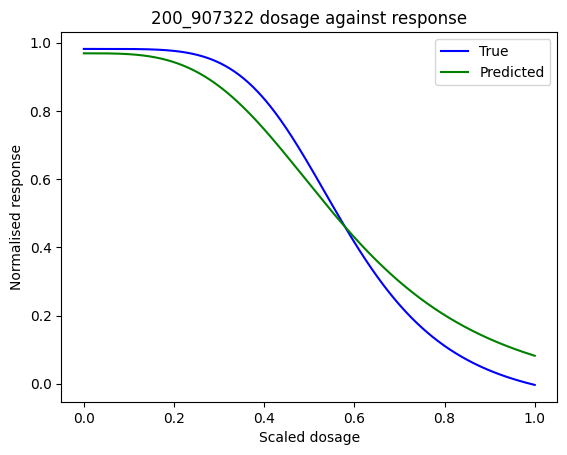

[-1.99885731  1.00898205  3.75846183 -0.14142444]


C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


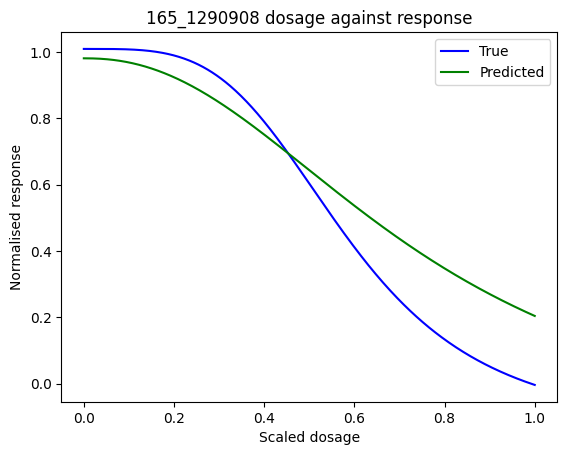

[-14.44326918   1.06737636  18.92715577   0.02011701]


C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


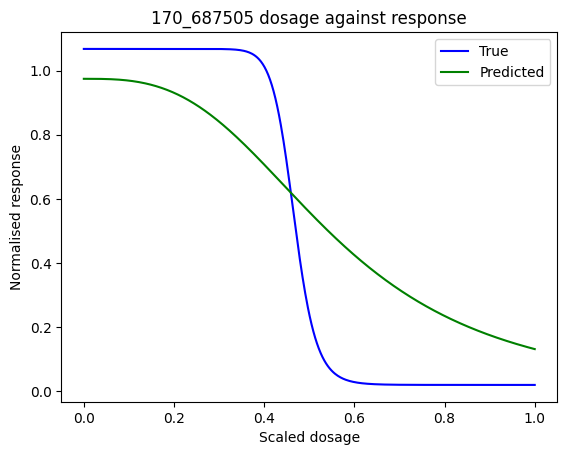

[-5.82621400e+00  1.03360231e+00  1.72489798e+01  6.07899300e-03]


C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\2987890562.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


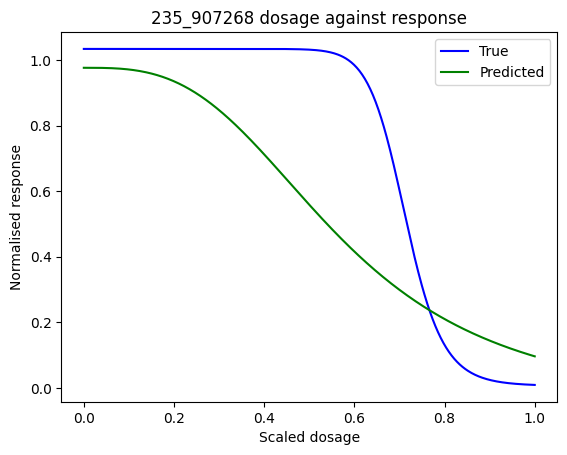

In [32]:
max_int = len(predictedOptimal.index)
rand_int = np.random.randint(0, max_int, 9)

for index in rand_int:
    showTestPredResponses(predictedOptimal.iloc[index]['DRUG_COSMICID'])

In [33]:
# Function to calculate the logistic regression
def ll4_R(x, c, a, b, d):
    return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)

# Load the datasets
boostingTuned = pd.read_csv(_FOLDER_3 + "boostingPredictedTuned.csv")
trueResults = pd.read_csv(_FOLDER_3 + "true_results.csv")
params = ['param_1', 'param_2', 'param_3', 'param_4']

# Initialize a list to store R2 scores
r2_scores = []
r2_scores_with_ids = []

# Iterate over each DRUG_COSMICID in trueResults
for ind, row in trueResults.iterrows():
    cosmicId = row['DRUG_COSMICID']
    trueParams = np.array(row[params])
    predParamsRow = boostingTuned[boostingTuned['DRUG_COSMICID'] == cosmicId]
    if not predParamsRow.empty:
        predParams = np.array(predParamsRow.iloc[0][params])
        xValues = np.linspace(0.0, 1.0, 100)
        trueYcalc = ll4_R(xValues, *trueParams)
        predYcalc = ll4_R(xValues, *predParams)
        r2Score = r2_score(trueYcalc, predYcalc)
        r2_scores.append(r2Score)
        r2_scores_with_ids.append((cosmicId, r2Score))


# Calculate and print the average R2 score
average_r2_score = sum(r2_scores) / len(r2_scores) if r2_scores else 0
median_r2 = np.median(r2_scores)

df_r2_scores = pd.DataFrame(r2_scores_with_ids, columns=['DRUG_COSMICID', 'R2_Score'])

C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\4234216777.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\4234216777.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\4234216777.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\4234216777.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\4234216777.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_29840\4234216777.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp

In [34]:
print(f"Average R2 score for Boosting Predicted Tuned: {average_r2_score}")
print(r2_scores)
print(f"Median R²: {median_r2}")

counts = {
    '>0.9': 0,
    '0.8-0.9': 0,
    '0.7-0.8': 0,
    '0.6-0.7': 0,
    '0.5-0.6': 0,
    '0.4-0.5': 0,
    '0.3-0.4': 0,
    '0.2-0.3': 0,
    '0.1-0.2': 0,
    '0-0.1': 0,
    '<0': 0
}

# Iterate over R² scores and increment the corresponding counter
for score in r2_scores:
    if score > 0.9:
        counts['>0.9'] += 1
    elif 0.8 < score <= 0.9:
        counts['0.8-0.9'] += 1
    elif 0.7 < score <= 0.8:
        counts['0.7-0.8'] += 1
    elif 0.6 < score <= 0.7:
        counts['0.6-0.7'] += 1
    elif 0.5 < score <= 0.6:
        counts['0.5-0.6'] += 1
    elif 0.4 < score <= 0.5:
        counts['0.4-0.5'] += 1
    elif 0.3 < score <= 0.4:
        counts['0.3-0.4'] += 1
    elif 0.2 < score <= 0.3:
        counts['0.2-0.3'] += 1
    elif 0.1 < score <= 0.2:
        counts['0.1-0.2'] += 1
    elif 0 < score <= 0.1:
        counts['0-0.1'] += 1
    else:  # score < 0
        counts['<0'] += 1

# Print counts
for category, count in counts.items():
    print(f"R² {category}: {count} scores")

Average R2 score for Boosting Predicted Tuned: 0.6884817263263778
[0.8603228108583273, 0.8967650666123927, 0.9099393207271139, 0.8491221174941931, 0.7279701253197217, 0.4336450670118118, -0.13788686173999887, 0.854814069414677, 0.8884592094163088, 0.7710123619233419, 0.9394261825715994, 0.8853996573708229, 0.43275818851481385, 0.9061413777907186, 0.7139170781015676, 0.8369106695853314, 0.055251731383557656, 0.895685588805097, 0.8424331774332255, 0.742824917868719, 0.27925134292721676, 0.6363663772354102, 0.8125995251999225, 0.7496758205340686, 0.9656734184611274, 0.5476768410972942, 0.7610389576415255, 0.12582102587490074, 0.7786926676223059, 0.8850963450602725, 0.773204855883317, 0.8680741708653993, 0.8103485343909345, 0.7943454955195075, 0.4384001554848759, 0.9093383992417794, 0.9912775196477615, 0.898436059711169, 0.5154126218972885, 0.5846671084125881, 0.6088253683376881, 0.7357974785366392, 0.7381222207555175, 0.8885426378061277, 0.04948690267299993, 0.569720680056722, 0.914132310

In [24]:
print(df_r2_scores)
df_r2_scores.to_csv(_FOLDER_3 + "r2_scores_with_ids2.csv", index=False)

    DRUG_COSMICID  R2_Score
0      200_687819  0.860323
1     1012_753594  0.896765
2     1024_905965  0.909939
3    1149_1247871  0.849122
4      173_907280  0.727970
..            ...       ...
495   173_1240153  0.976531
496    157_909262  0.912506
497    272_684055  0.949023
498   104_1330981  0.729102
499    219_910926  0.876813

[500 rows x 2 columns]
